# Simulating a news personalization scenario using Contextual Bandits


In [1]:
# necessary imports
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
from functools import partial

# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

# sample from a given pmf array
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

# get the actions
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

"""
    Simulation Setup, run simulation and the plotting functions
"""

# simulation setup
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

# run simulation
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

# the plotting function
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## Part-1 Multiple changes to the reward distribution over time

Here, we have tried changing the cost functions over time in multiple scenarios.



In [2]:
# define the cost functions

# the default cost function which was provided
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

# the get_cost_new1 function given in the tutorial 
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

# new cost function added by me 
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'finance':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

# new cost function added by me
def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
# simulation runner for multiple cost functions
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

View of the preferences for the different cost functions

In [3]:
get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [4]:
get_preference_matrix(get_cost_new1)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [5]:
get_preference_matrix(get_cost_new2)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0  -1.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0     -1.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0  -1.0     0.0    0.0       0.0     0.0

In [6]:
get_preference_matrix(get_cost_new3)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0  -1.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0   -1.0       0.0     0.0

Define a generic function which takes in the list of cost functions and plots
all the learning algorithms


In [7]:
def get_plot_multiple_explorations(cost_functions, learn=True):
    # list down the different eplorations first
    vw_eps = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
    vw_first = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")
    vw_bag = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")
    vw_softmax = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")
    vw_cover = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 3")
    
    # now run it and plot
    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(cost_functions)

    ctr_eps = run_simulation_multiple_cost_functions(vw_eps, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=learn)
    ctr_first = run_simulation_multiple_cost_functions(vw_first, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=learn)
    ctr_bag = run_simulation_multiple_cost_functions(vw_bag, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=learn)
    ctr_softmax = run_simulation_multiple_cost_functions(vw_softmax, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=learn)
    ctr_cover = run_simulation_multiple_cost_functions(vw_cover, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=learn)
    
    # plot all of the plots in a single plot
    plt.figure()
    plt.plot(range(1,total_iterations+1), ctr_eps, label="epsilon-greedy")
    plt.plot(range(1,total_iterations+1), ctr_first, label="eplore-first")
    plt.plot(range(1,total_iterations+1), ctr_bag, label="bagging")
    plt.plot(range(1,total_iterations+1), ctr_softmax, label="softmax")
    plt.plot(range(1,total_iterations+1), ctr_cover, label="online cover")                       
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.legend()
    plt.ylim([0,1])

## no time variant distribution
Now run the scenario with no time variance

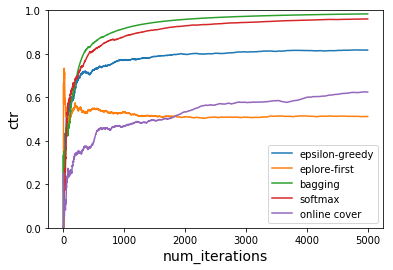

In [8]:
get_plot_multiple_explorations([get_cost])

Adding time Variance - 2 cost functions

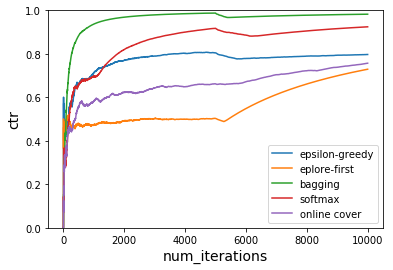

In [9]:
get_plot_multiple_explorations([get_cost, get_cost_new1])

Adding time Variance - 3 cost functions

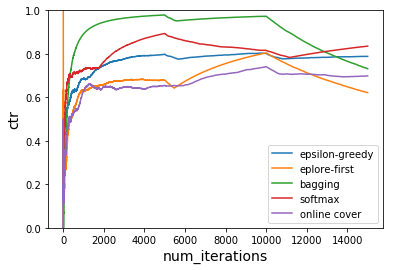

In [10]:
get_plot_multiple_explorations([get_cost, get_cost_new1, get_cost_new2])

Adding time variance - 4 cost functions

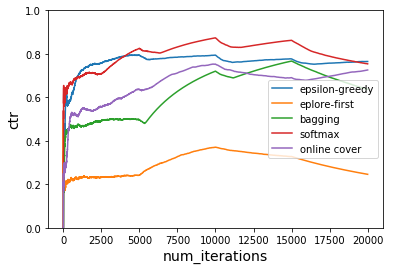

In [11]:
get_plot_multiple_explorations([get_cost, get_cost_new1, get_cost_new2, get_cost_new3])

### Inference from above and thoughts




## Part-2 Adding Varying noise in the reward distribution

To simulate varying noise, I’m going to add small random noise (between 0 and 0.5) to the cost
function. This guaranteees that “liked articles” will always have a negative cost (value unknown)
and disliked articles will have a 0 or positive cost. The preference matrix below is an example of
one set of preferences. When the simulation is run, the preference matrix will change.

In [12]:
# the noise cost function
def get_cost_added_noise_low(context,action):
    bound = 0.25
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        else:
            return USER_DISLIKED_ARTICLE + random.uniform(-bound, bound)
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        else:
            return USER_DISLIKED_ARTICLE + random.uniform(-bound, bound)

def get_cost_added_noise_high(context,action):
    bound = 0.5
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        else:
            return USER_DISLIKED_ARTICLE + random.uniform(-bound, bound)
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE + random.uniform(-bound, bound)
        else:
            return USER_DISLIKED_ARTICLE + random.uniform(-bound, bound)


Now we plot for no, low, high variance noises and compare them

1) No noise

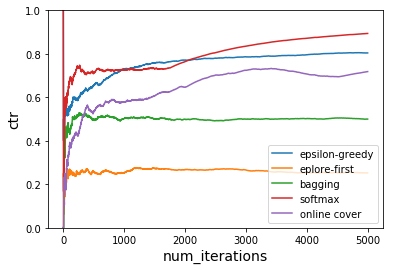

In [13]:
get_plot_multiple_explorations([get_cost])

2) With noise ~ U(0.25, 0.25)

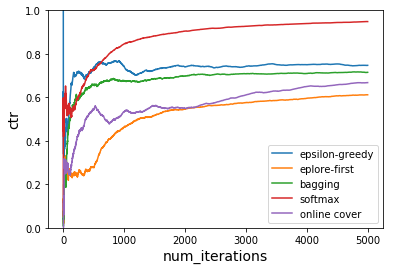

In [14]:
get_plot_multiple_explorations([get_cost_added_noise_low])

3) With noise ~ U(0.5, 0.5)

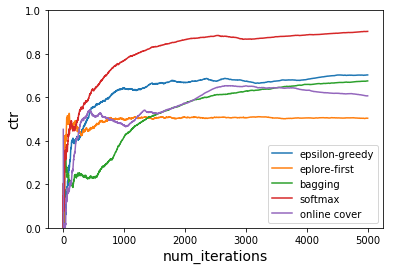

In [15]:
get_plot_multiple_explorations([get_cost_added_noise_high])

##  Inferences